In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import seaborn as sns

In [2]:
def create_test_image(size=128):
    """Create a test image with three intensity levels and a circle pattern."""
    img = np.ones((size, size)) * 0.5
    center = size // 2
    y, x = np.ogrid[-center:size-center, -center:size-center]

    mask_outer = x*x + y*y <= (size//3)**2
    img[mask_outer] = 0.75

    mask_inner = x*x + y*y <= (size//4)**2
    img[mask_inner] = 1.0

    return img

def add_noise(image, noise_type, params):
    """Add different types of noise to the image."""
    noisy = image.copy()
    if noise_type == 'gaussian':
        noise = np.random.normal(0, params['sigma'], image.shape)
        noisy = image + noise
    elif noise_type == 'salt':
        mask = np.random.random(image.shape) < params['prob']
        noisy[mask] = 1.0
    elif noise_type == 'pepper':
        mask = np.random.random(image.shape) < params['prob']
        noisy[mask] = 0.0
    elif noise_type == 'salt_and_pepper':
        mask = np.random.random(image.shape) < params['prob']/2
        noisy[mask] = 1.0
        mask = np.random.random(image.shape) < params['prob']/2
        noisy[mask] = 0.0

    return np.clip(noisy, 0, 1)

def arithmetic_mean_filter(image, kernel_size):
    """Apply arithmetic mean filter."""
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    return signal.convolve2d(image, kernel, mode='same', boundary='symm')

def geometric_mean_filter(image, kernel_size):
    """Apply geometric mean filter."""
    kernel = np.ones((kernel_size, kernel_size))
    log_image = np.log(image + 1e-10)
    filtered = signal.convolve2d(log_image, kernel, mode='same', boundary='symm')
    filtered = filtered / (kernel_size * kernel_size)
    return np.exp(filtered)

def harmonic_mean_filter(image, kernel_size):
    """Apply harmonic mean filter."""
    kernel = np.ones((kernel_size, kernel_size))
    inverse_image = 1 / (image + 1e-10)
    filtered = signal.convolve2d(inverse_image, kernel, mode='same', boundary='symm')
    return (kernel_size * kernel_size) / filtered

def contraharmonic_mean_filter(image, kernel_size, Q):
    """Apply contraharmonic mean filter with order Q."""
    kernel = np.ones((kernel_size, kernel_size))
    numerator = signal.convolve2d(np.power(image + 1e-10, Q + 1), kernel, mode='same', boundary='symm')
    denominator = signal.convolve2d(np.power(image + 1e-10, Q), kernel, mode='same', boundary='symm')
    return numerator / denominator

def double_contraharmonic_filter(image, kernel_size, Q1, Q2):
    """Apply contraharmonic filter twice with different Q values."""
    first_pass = contraharmonic_mean_filter(image, kernel_size, Q1)
    return contraharmonic_mean_filter(first_pass, kernel_size, Q2)

def calculate_metrics(original, filtered):
    """Calculate multiple image quality metrics."""
    return {
        'PSNR': psnr(original, filtered, data_range=1.0),
        'SSIM': ssim(original, filtered, data_range=1.0),
        'MSE': mse(original, filtered),
        'MAE': np.mean(np.abs(original - filtered))
    }



In [3]:
def run_experiments():
    # Create original image
    original = create_test_image()
    kernel_size = 3

    # Define noise parameters
    noise_params = {
        'gaussian': {'sigma': 0.1},
        'salt': {'prob': 0.1},
        'pepper': {'prob': 0.1},
        'salt_and_pepper': {'prob': 0.1}
    }

    # Define filters with both positive and negative Q values
    filters = {
        'Arithmetic': lambda img: arithmetic_mean_filter(img, kernel_size),
        'Geometric': lambda img: geometric_mean_filter(img, kernel_size),
        'Harmonic': lambda img: harmonic_mean_filter(img, kernel_size),
        'Contraharmonic (Q=1.5)': lambda img: contraharmonic_mean_filter(img, kernel_size, 1.5),
        'Contraharmonic (Q=-1.5)': lambda img: contraharmonic_mean_filter(img, kernel_size, -1.5),
        'Double Contraharmonic\n(Q1=1.5,Q2=-1.5)': lambda img: double_contraharmonic_filter(img, kernel_size, 1.5, -1.5)
    }

    # Store results
    results = {}

    # Create a figure for all noise types with spacing
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(len(noise_params), 1, height_ratios=[1]*len(noise_params), hspace=0.4)

    # Run experiments for each noise type
    for noise_idx, (noise_type, params) in enumerate(noise_params.items()):
        # Create noisy image
        noisy = add_noise(original, noise_type, params)

        # Apply filters and calculate metrics
        noise_results = {}
        for filter_name, filter_func in filters.items():
            filtered = filter_func(noisy)
            metrics = calculate_metrics(original, filtered)
            noise_results[filter_name] = metrics

        results[noise_type] = noise_results

        # Create subplot for this noise type
        inner_gs = gs[noise_idx].subgridspec(1, 8, wspace=0.3)  # Increased number of columns and spacing
        axes = [fig.add_subplot(inner_gs[0, i]) for i in range(8)]

        plt.suptitle('Filter Comparison - Different Noise Types', fontsize=16, y=0.95)

        # Plot original and noisy images
        axes[0].imshow(original, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original', fontsize=10)
        axes[0].axis('off')

        axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=1)
        axes[1].set_title(f'Noisy\n({noise_type.replace("_", " ").title()})', fontsize=10)
        axes[1].axis('off')

        # Plot filtered images
        for idx, (filter_name, filter_func) in enumerate(filters.items()):
            filtered = filter_func(noisy)
            axes[idx+2].imshow(filtered, cmap='gray', vmin=0, vmax=1)
            axes[idx+2].set_title(f'{filter_name}\nPSNR: {results[noise_type][filter_name]["PSNR"]:.2f}',
                              fontsize=8)
            axes[idx+2].axis('off')

    plt.tight_layout()
    plt.show()

    # Create heatmap comparison for all metrics
    metrics = ['PSNR', 'SSIM', 'MSE', 'MAE']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Performance Metrics Comparison', fontsize=14)

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        data = np.zeros((len(noise_params), len(filters)))

        for i, noise_type in enumerate(noise_params.keys()):
            for j, filter_name in enumerate(filters.keys()):
                data[i, j] = results[noise_type][filter_name][metric]

        sns.heatmap(data,
                   ax=ax,
                   xticklabels=list(filters.keys()),
                   yticklabels=list(noise_params.keys()),
                   annot=True, fmt='.2f', cmap='viridis')

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
        ax.set_title(f'{metric} Comparison')

    plt.tight_layout()
    plt.show()

    return results


<ipython-input-3-2302f4ab358d>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


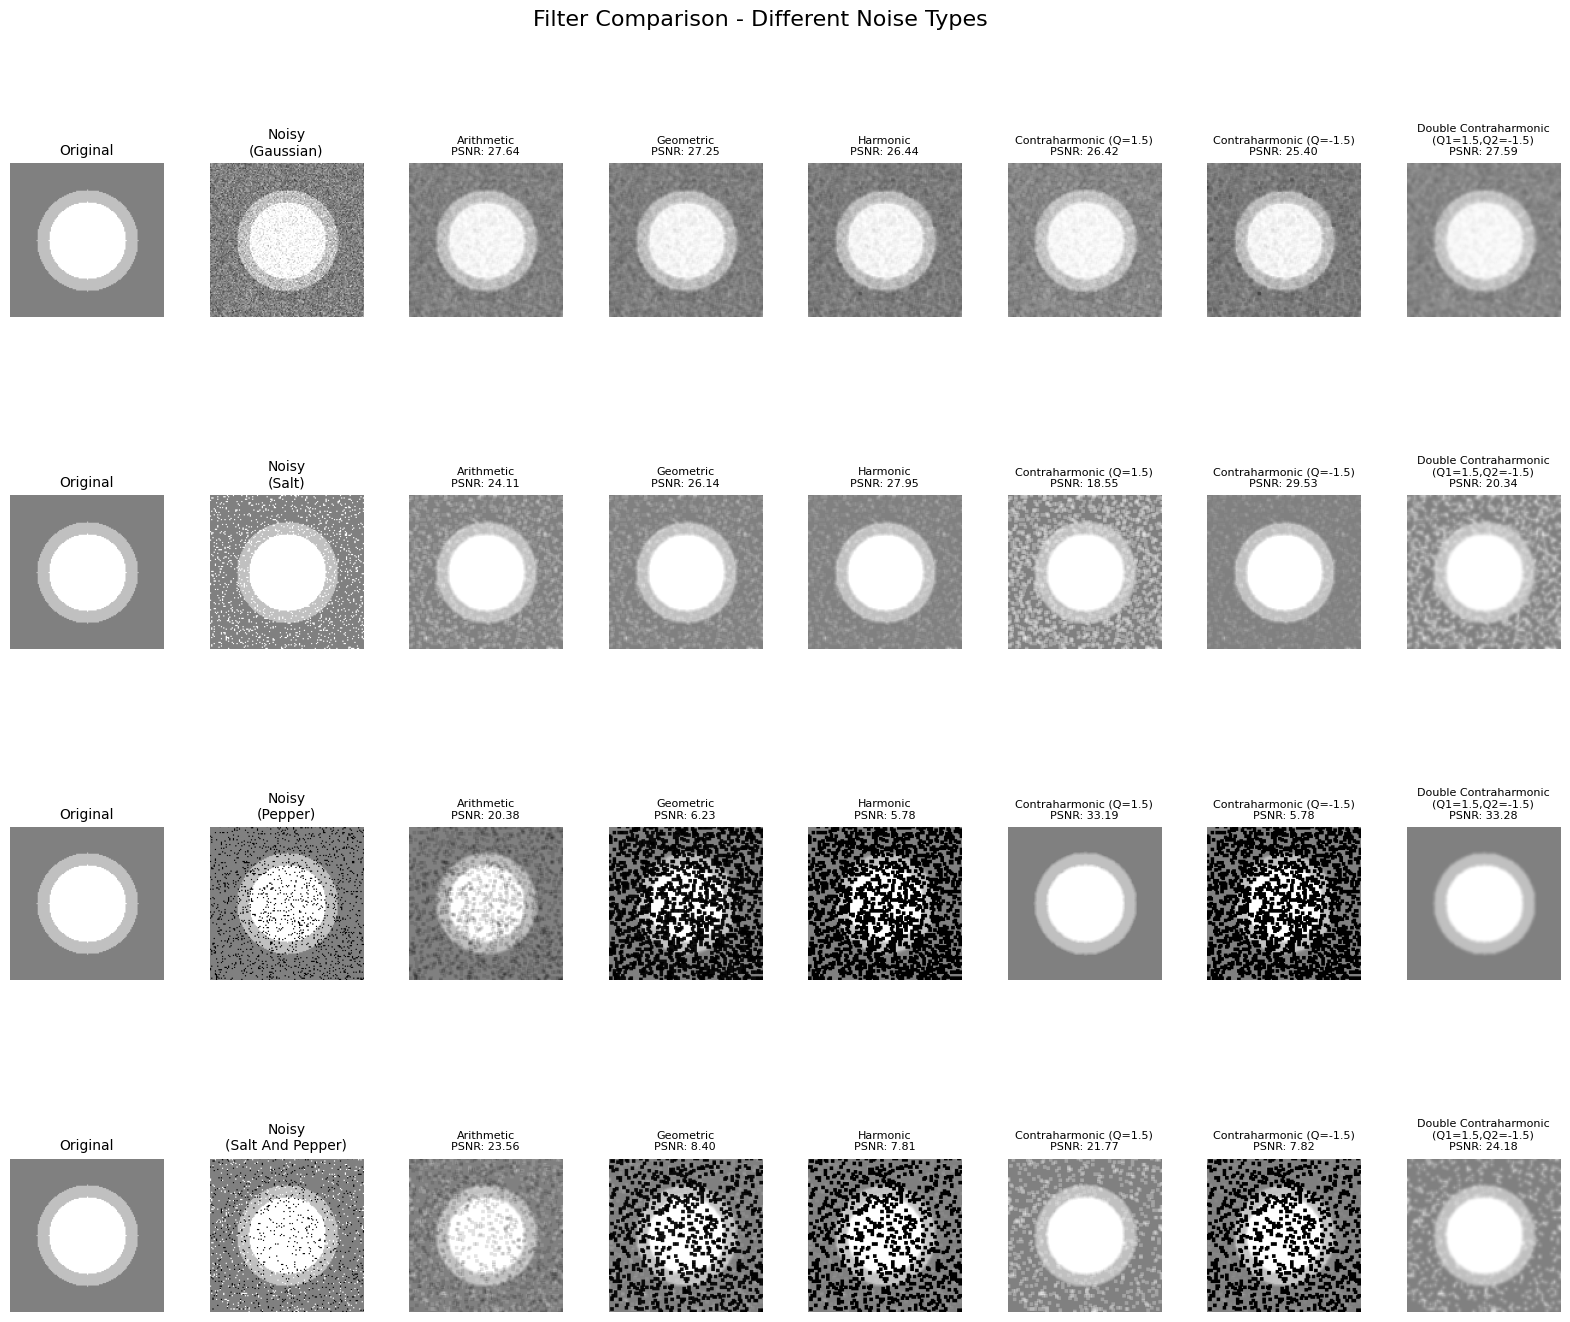

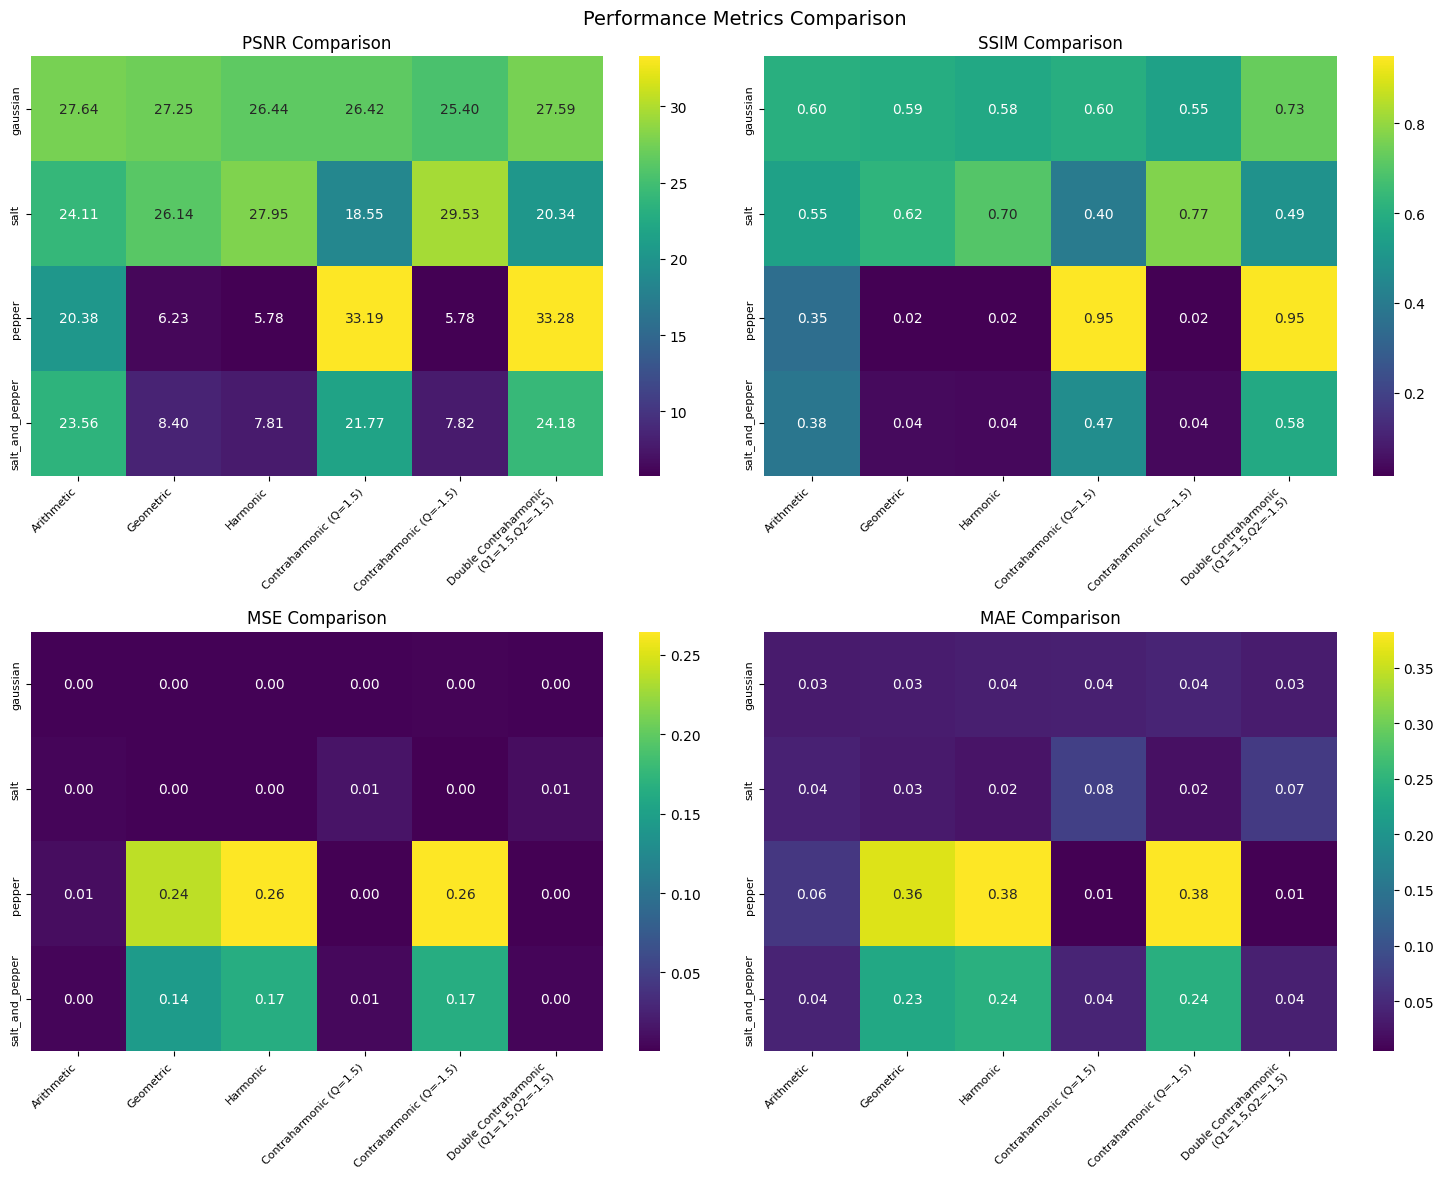

In [4]:

# Run experiments and get results
results = run_experiments()